# Algoritmo de Programação Inteira

In [1]:

import pandas as pd
import random
import math
import time
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpBinary, PULP_CBC_CMD
import re
import matplotlib.pyplot as plt
import orloge as ol

In [2]:
# Função para ler e processar os dados dos monitores e disciplinas a partir de um arquivo Excel.
# Ela lê o arquivo, limpa os nomes das colunas, remove duplicatas e extrai as colunas relevantes.
# Retorna um dicionário de alunos, uma lista de notas (Na) e uma matriz de disponibilidade (s_ad).
# Parâmetro:
# - path (str): Caminho para o arquivo Excel.
# Retornos:
# - alunos (dict): Dicionário onde a chave é o número USP e contem as seguintes informacoes --
#  -- > [Interesse em ser voluntario(ignorar), pontuacao do aluno (float), criterio de desempate (1, 2 ou 3), lista de materias que ele esta inscrito (Ex: [38, 39, 40]]).
# - Na (list): Lista das notas dos alunos.
# - s_ad (list of lists): Matriz binária de disponibilidade dos alunos para disciplinas.
def ler_dados(path):
    # Padroniza o nome das colunas, para facilitar extracao
    def limpar_nome_coluna(nome):
        return ' '.join(nome.strip().split()).lower()

    # Le e extrai as colunas necessarias
    df = pd.read_excel(path)
    df.columns = [limpar_nome_coluna(col) for col in df.columns]
    df = df.drop_duplicates(subset=['nºusp'], keep='last') # mantem apenas a ultima ocorrencia de um NUSP

    colunas_n = [
        'nºusp',
        'possui pedido de bolsa de estudos em andamento? (a concessão de bolsa de estudos implicará no cancelamento da monitoria a partir do início da vigência da bolsa)',
        'pretende se inscrever no peeg? (o acúmulo das duas monitorias não é permitido. caso o aluno seja selecionado nas duas modalidades precisará optar por uma delas)',
        'departamento de matemática (início da monitoria em 05/08/2024)',
        'departamento de matemática aplicada e estatística (início da monitoria em 05/08/2024)',
        'departamento de ciências de computação (início da monitoria em 05/08/2024)',
        'departamento de sistemas de computação (início da monitoria em 01/09/2024)',
        'tem interesse na monitoria voluntária (sem recebimento de bolsa)?',
        'média ponderada com reprovações'
    ]

    df_colunas = df[colunas_n].copy()

    # Calcula a pontuacao para criterio de desempate dos alunos (3 - mais prioridade, 2 - prioridade media, 1 - prioridade baixa)
    def calcular_pontuacao(row):
        bolsa = row[colunas_n[1]]
        peeg = row[colunas_n[2]]
        if bolsa == 'Sim' and peeg == 'Sim':
            return 1
        elif bolsa == 'Não' and peeg == 'Não':
            return 3
        return 2

    df_colunas['bolsa_peeg_status'] = df_colunas.apply(calcular_pontuacao, axis=1)
    df_colunas = df_colunas.drop([colunas_n[1], colunas_n[2]], axis=1)

    # Faz o mapeamento dos departamentos presentes na planilha
    departamento_mapping = {
        colunas_n[3]: 1,
        colunas_n[4]: 2,
        colunas_n[5]: 3,
        colunas_n[6]: 4
    }

    # Extrai as materias presentes na planilha
    materias_set = set()
    materias_dict = {}
    materia_index = 0

    for dept_col, dept_num in departamento_mapping.items():
        for materias in df_colunas[dept_col].dropna():
            for materia in materias.split(','):
                materia = materia.strip()
                if materia not in materias_set:
                    materias_set.add(materia)
                    materias_dict[materia_index] = (materia, dept_num)
                    materia_index += 1

    # Extrai os alunos, sua nota, sua pontuacao de desempate, se tem interesse em ser voluntario e as materias que ele se inscreveu
    alunos = df_colunas.set_index('nºusp').T.to_dict('list')

    Na = []
    for usp, valores in alunos.items():
        materias_combinadas = []
        valores_limpos = []
        for valor in valores:
            if isinstance(valor, str) and '-' in valor:
                for materia in valor.split(','):
                    materia = materia.strip()
                    for indice, (mat, dept) in materias_dict.items():
                        if materia == mat:
                            materias_combinadas.append(indice)
                            break
            elif isinstance(valor, str) and (valor.upper() == 'POS' or valor.upper() == 'PÓS'): # atribui a nota 1 caso o aluno for da pos, para diminuir sua prioridade
                valores_limpos.append(1)
            elif not pd.isna(valor):
                valores_limpos.append(valor)

        if materias_combinadas:
            valores_limpos.append(sorted(materias_combinadas))

        alunos[usp] = valores_limpos
        nota = valores_limpos[1] if len(valores_limpos) > 1 else None
        Na.append(nota)

    s_ad = [
        [1 if materia in valores_limpos[-1] else 0 for materia in materias_dict.keys()]
        for usp, valores_limpos in alunos.items()
    ]

    return alunos, Na, s_ad

In [3]:
# Função para criar o modelo de otimização de alocação de monitores com base nos dados fornecidos.
# Parâmetros:
# - alunos (dict): Dicionário de alunos (informações como notas, disponibilidade etc).
# - Na (list): Lista de notas dos alunos.
# - s_ad (list of lists): Matriz de disponibilidade dos alunos para disciplinas.
# - materias (list): Lista de todas as disciplinas.
# Retorno: Deve retornar o modelo de otimização, variáveis e os dados para análise posterior.
def criar_modelo(alunos, Na, s_ad, materias):
    # Voce deve implementar esta parte (foi deixado um exemplo de como pegar os parametros)
    # Esta é apenas uma sugestão de implementacao, voce pode mudar esta funcao se desejar ou ate criar o modelo
    # diretamente no codigo sem usar uma funcao (recomendo fortemente que nao faca isso)

    # Conjunto de monitores (A) e disciplinas (D)
    A = list(range(len(alunos)))
    D = materias

    '''
    Modelo de Otimizacao
    '''
    modelo = LpProblem("Alocacao_de_Monitores", LpMaximize)

    # Variaveis de decisao
    x_ad = LpVariable.dicts("x", [(a, d) for a in A for d in D], cat=LpBinary)
    y_d = LpVariable.dicts("y", D, cat=LpBinary)

    # Funcao objetivo
    modelo += lpSum(Na[a] * x_ad[(a, d)] for a in A for d in D) - lpSum(y_d[d] for d in D)

    '''
    Restrições
    '''

    # Cada disciplina deve ter no maximo um monitor ou nao ter monitor
    for d in D:
        modelo += lpSum(x_ad[(a, d)] for a in A) + y_d[d] == 1, f"Restricao_disciplina_{d}"

    # Cada monitor pode ser alocado a no maximo uma disciplina
    for a in A:
        modelo += lpSum(x_ad[(a, d)] for d in D) <= 1, f"Restricao_monitor_{a}"

    # Um monitor so pode ser alocado a uma disciplina se ele estiver disposto (s_{ad} = 1)
    for a in A:
        for d in D:
            modelo += x_ad[(a, d)] <= s_ad[a][d], f"Restricao_disposicao_{a}_{d}"


    return modelo, x_ad, y_d, D

# Função para resolver o modelo de otimização com base em parâmetros fornecidos.
# Parâmetros:
# - modelo (pulp.LpProblem): O modelo de otimização que será resolvido.
# - presolve (int): Se 1, presolve é ativado; se 0, é desativado.
# - cortes (int): Intensidade da geracao de cortes (0 desativa).
# Retorno: O modelo resolvido.
def resolver_modelo(modelo, presolve, cortes):
    # Configurar as opções do solver
    modelo.preprocess = presolve  # Define preprocess (-1, 0, 1)
    
    modelo.cuts = cortes  # Define geração de cortes (-1, 0, 1, 2, 3)

    # Medir o tempo de execução
    start_time = time.time()

    # Resolver o modelo
    solver = PULP_CBC_CMD(msg=False, logPath='cbc_solver.log', timeLimit=30 * 60) # Time Limit de 30 min
    modelo.solve(solver)

    # Calcular o tempo de execução
    execution_time = time.time() - start_time

    # Exibir as informações do modelo resolvido
    print(f"Solução Encontrada: {modelo.objective.value}")
    # print(f"Gap: {modelo.gap * 100:.2f}%")
    print("Status da solução:", modelo.status, modelo.status)
    print(f"Tempo de execução: {execution_time:.2f} segundos")

    gap = get_gap_from_log('cbc_solver.log')

    print(f'gap = {gap}')

    if(gap == None):
        print('gap None')

    return modelo, modelo.objective.value(), execution_time, gap

# Função para exibir as informações dos monitores alocados e não alocados, além das disciplinas não atendidas.
# Parâmetros:
# - m (pulp.LpProblem): O modelo de otimização resolvido.
# - x_ad (dict): Variáveis de decisão indicando a alocação dos monitores às disciplinas.
# - y_d (dict): Variáveis de decisão indicando disciplinas não atendidas.
# - alunos (dict): Dicionário contendo as informações dos alunos.
# - D (list): Lista de disciplinas disponíveis.
# - s_ad (list of lists): Matriz de disponibilidade dos monitores para as disciplinas.
# Retorno: Nenhum. A função imprime os resultados diretamente.
def informacoes_monitores(m, x_ad, y_d, alunos, D, s_ad):
    monitores_alocados = []
    monitores_nao_alocados = []
    disciplinas_atendidas = set()  # Conjunto para armazenar as disciplinas atendidas

    # Exibe os monitores alocados para disciplinas
    for a in range(len(alunos)):
        alocado = False
        for d in D:
            if x_ad[(a,d)].varValue >= 0.99:  # Verifica se a variável é 1
                monitores_alocados.append(f"Monitor {list(alunos.keys())[a]} foi alocado para a disciplina {d}.")
                alocado = True
                disciplinas_atendidas.add(d)  # Adiciona a disciplina ao conjunto de disciplinas atendidas

        # Caso o monitor não tenha sido alocado, armazenar a informação para exibir depois
        if not alocado:
            disciplinas_inscrito = [d for d in D if s_ad[a][d] == 1]
            monitores_nao_alocados.append(f"Monitor {list(alunos.keys())[a]} NÃO foi alocado. Inscrito para as disciplinas: {disciplinas_inscrito}")

    # # Exibir os monitores alocados
    # print("\nMonitores alocados:")
    # for alocacao in monitores_alocados:
    #     print(alocacao)

    # # Exibir os monitores não alocados
    # print("\nMonitores não alocados:")
    # for nao_alocacao in monitores_nao_alocados:
    #     print(nao_alocacao)

    # # Mostrar disciplinas não atendidas e os monitores que se inscreveram para elas
    # print("\nDisciplinas não atendidas e seus inscritos:")
    # for d in D:
    #     if y_d[d].varValue >= 0.99:  # Verifica se a variável é 1 (disciplina não atendida)
    #         monitores_inscritos = [list(alunos.keys())[a] for a in range(len(alunos)) if s_ad[a][d] == 1]
    #         if monitores_inscritos:
    #             print(f"A disciplina {d} não foi atendida por nenhum monitor. Inscritos: {monitores_inscritos}")
    #         else:
    #             print(f"A disciplina {d} não foi atendida por nenhum monitor e não possui inscritos.")

    return len(disciplinas_atendidas)
  


'''
FUNÇÃO PARA PEGAR O GAP
'''
def get_gap_from_log(path):
    try:
        with open(path, 'r') as f:

            logs_dict = ol.get_info_solver(path, 'CBC') # Orloge returns a dict with all logs info

            best_bound, best_solution = logs_dict["best_bound"], logs_dict["best_solution"]

            # print(f'best_bound = {best_bound}')
            # print(f'best_solution = {best_solution}')
            # print(f'logs_dict = {logs_dict}')

            if best_bound is not None and best_solution is not None :
                gap = abs(best_solution - best_bound) / (1e-10 + abs(best_bound)) * 100 # Gap in %. We add 1e-10 to avoid division by zero.
                return gap
            else :
                print("Unable to retrieve gap.")
                return None

    except FileNotFoundError:
        print("Arquivo de log não encontrado.")
        return None


In [4]:
# Função para aumentar os dados de alunos e matérias com base na escala fornecida.
# Parâmetros:
# - file_path (str): Caminho para o arquivo Excel com os dados originais.
# - escala (float): Fator de aumento dos dados (e.g., 1.5 para aumentar em 50%).
# Retorno: Retorna os dados aumentados (alunos, notas, disponibilidade dos alunos para disciplinas e a lista de matérias).
def aumentar_dados(path, escala):
    # Lê os dados originais usando a função existente
    alunos_originais, Na_originais, s_ad_originais = ler_dados(path)
    seed = 0

    # Se seed for 0 e escala for 1, retornar os dados originais
    if seed == 0 and escala == 1:
        todas_materias = list(range(len(s_ad_originais[0])))
        return alunos_originais, Na_originais, s_ad_originais, todas_materias

    # Define a seed para a geração de dados aleatórios
    if seed is not None:
        random.seed(seed)

    novos_alunos = {}
    novas_notas = []
    nova_s_ad = []
    usp_existentes = set(alunos_originais.keys())
    max_usp = max(usp_existentes)

    # Aumenta o número de materias em 1.12x com base na escala
    num_materias_originais = len(s_ad_originais[0])
    num_novas_materias = math.ceil(num_materias_originais * 1.12 * escala)

    # Novos índices para as matérias que serão adicionadas
    novas_materias = list(range(num_materias_originais, num_materias_originais + num_novas_materias))

    # Aumenta o numero de alunos conforme a escala
    total_alunos = len(alunos_originais)
    num_novos_alunos = math.ceil(total_alunos * (escala - 1))  # Cria novos alunos além dos originais

    # Cria os novos alunos
    for i in range(num_novos_alunos):
        # Novo Nusp
        max_usp += 1
        novo_usp = max_usp
        usp_existentes.add(novo_usp)

        # Gerar uma nova nota aleatória para o novo aluno
        nova_nota = random.uniform(0, 10)
        novas_notas.append(nova_nota)

        # Gerar matérias aleatórias (entre 2 e 4) para cada novo aluno
        num_materias_aluno = random.randint(2, 4)
        todas_materias = list(range(num_materias_originais)) + novas_materias  # Considera matérias antigas e novas
        materias_aluno = random.sample(todas_materias, num_materias_aluno)

        # Criar a matriz de disponibilidade (s_ad) para o novo aluno com as matérias selecionadas
        disponibilidade_aluno = [1 if materia in materias_aluno else 0 for materia in todas_materias]
        nova_s_ad.append(disponibilidade_aluno)

        novos_alunos[novo_usp] = []

    # Expande a matriz s_ad original para acomodar as novas matérias
    s_ad_expandidos = [row + [0] * len(novas_materias) for row in s_ad_originais]
    s_ad_expandidos += nova_s_ad

    # Combinar os dados originais e os novos
    alunos_expandidos = {**alunos_originais, **novos_alunos}
    Na_expandidos = Na_originais + novas_notas

    # Criar a lista ordenada de NUSP
    alunos_list = list(alunos_originais.keys()) + list(novos_alunos.keys())

    return alunos_expandidos, Na_expandidos, s_ad_expandidos, todas_materias, alunos_list

In [5]:
%%capture

# Caminho do arquivo Excel com os dados originais
path = '/home/greff/Desktop/scheduler-class-assistant/dataset/Dados_monitores.xlsx'

escalas = [2, 3, 5, 10, 15]
temp_inteiro = []
salas_atendidas_inteiro = []

for esc in escalas:

    # Aumenta os dados de alunos e matérias
    alunos, Na, s_ad, materias, _ = aumentar_dados(path, escala=esc)

    # Cria o modelo de otimização com os dados aumentados
    mod, x_ad, y_d, D = criar_modelo(alunos, Na, s_ad, materias)

    # Resolve o modelo
    m, obj, t, _ = resolver_modelo(mod, 1, 1)

    temp_inteiro.append(t)

    qtd = informacoes_monitores(m, x_ad, y_d, alunos, D, s_ad)

    salas_atendidas_inteiro.append(qtd)


In [6]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools
from multiprocessing import *
import warnings
warnings.filterwarnings("ignore")

""" LEGENDA
c: candidatos
d: disciplinas
i: individuos
p: preferências
"""

def adicionar_aluno(da:dict, d:str, a:int):
    if d in da:
        da[d].append(a)
    else:
        da[d] = [a]

def criar_individuo(d, da):
    """ 
    Os individuos são criados como se fossem a lista de disciplinas,
    sendo certo que cada valor é o nUSP do candidato. Caso a quantidade 
    de candidatos seja menor que a de disciplinas, serão preenchidos zeros
    até total de disciplinas.
    """
    i = []
    escolhidos = set()
    for alunos in d:
        a = set(da[alunos])
        a = list(a - escolhidos)
        if len(a) != 0:
            escolhido = random.choice(a)
            escolhidos.add(escolhido)
            i.append(escolhido)
        # Representa sala sem candidatos ou que os candidatos 
        # foram escolhidos para outras disciplinas
        else: 
            i.append(0)
    return i

def contar_salas(i, d, p):
    """ 
    Na evolução, os monitores podem ser designados para salas equivocadas.
    Por isso, precisamos checar se eles possuem formação na disciplina. A
    quantidade de salas reflete as designações corretas.
    """
    check = []
    for indice, valor in enumerate(i):
        if valor == 0: continue
        # dict_keys(['SME0341 - Álgebra Linear e Equações Diferenciais'])
        check.append(d[indice] in p[valor].keys())
    return sum(check)

def medir_satisfacao(i, d, p):
    """ 
    A satisfação do conjunto de monitores foi modelada utilizando uma 
    função exponencial, a qual atribui maior valor para preferência 1 
    e menor valor para a última disciplina. 
    """
    preferencias = []
    for indice, valor in enumerate(i):
        opcoes = p.get(valor, {})
        x = opcoes.get(d[indice], {})
        if valor == 0 or x == {}: 
            x = 0.0
        preferencias.append(np.exp(-0.4 * (x - 1)))
    return sum(preferencias)

def avaliar_individuo(i, d, p):
    """ 
    A avaliação do individuo é uma função de distância em relação à origem.
    Nesse caso, temos a quantidade de salas no eixo X e a satisfação do 
    conjunto de monitores no eixo y. Objetiva-se aumentar os valores em X e
    Y. Por isso, quanto maior o valor, melhor o resultado. Atribui-se peso
    na sala porque o quesito deve prevalecer sobre a satisfação dos monitores.
    """
    salas = len(i)*contar_salas(i, d, p)
    interesses = medir_satisfacao(i, d, p)
    return np.linalg.norm([salas, interesses]),

def do_the_scheduled(disciplinas, candidatos, preferencias, da, resultados):
    """ 
    Função paralelizada que recebe os dados de processamento e inicia um
    algoritmo genético para realizar uma busca heurística. A cada geração
    serão criados 2000 indivíduos e ao final serão preservados 10% da população
    mais adaptada (melhor avaliada). Em 20% dos indivíduos, haverá mutações aleatórias, 
    entendidas como embaralhamento dos elementos dos indivíduos (visando 
    explorar o espaço de busca).
    """
    tamanho_populacao = 1000
    n_geracoes = 200
    preservacao = 0.2

    creator.create('FitnessMax', base.Fitness, weights=(1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('individual', tools.initIterate, creator.Individual, lambda: criar_individuo(disciplinas, da))
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)
    toolbox.register('evaluate', lambda ind: avaliar_individuo(ind, disciplinas, preferencias))
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register('select', tools.selBest)

    pop = toolbox.population(n=tamanho_populacao)

    for _ in range(n_geracoes):
        for ind in pop:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        elitismo = int(preservacao * len(pop))
        elite = toolbox.select(pop, elitismo)

        offspring = toolbox.clone(pop)
        for mutant in offspring:
            if random.random() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        for ind in offspring:
            if not ind.fitness.valid:
                ind.fitness.values = toolbox.evaluate(ind)

        pop[:] = elite + offspring[:len(pop) - elitismo]

    resultados.put(tools.selBest(pop, 1)[0])
    
def process_template_excel(excel_path:str) -> pd.DataFrame:
    df = pd.read_excel(excel_path)
    
    if 'NUSP' not in df.columns:
            raise Exception('Coluna "NUSP" é obrigatória na tabela dos monitores!')
            
    if 'Disciplina' not in df.columns:
        raise Exception('Coluna "Disciplina" é obrigatória na tabela dos monitores!')
        
    if 'Turma' not in df.columns:
        raise Exception('Coluna "Turma" é obrigatória na tabela dos monitores!')
        
    if 'Nota' not in df.columns:
        raise Exception('Coluna "Nota" é obrigatória na tabela dos monitores!')
        
    if 'Preferencia' not in df.columns:
        raise Exception('Coluna "Preferencia" é obrigatória na tabela dos monitores!') 
    
    df = df[['NUSP', 'Disciplina', 'Turma', 'Nota', 'Preferencia']]
    
    df['Disciplina'] = df['Disciplina'] + ' - Turma ' + df['Turma'].astype(str)
    
    disciplinas = list(df['Disciplina'].unique())
    candidatos = [i.item() for i in df['NUSP'].unique()]
    
    preferencias = {}
    for candidato in candidatos:
        df_filtrado = df[df['NUSP'] == candidato].copy().sort_values('Preferencia')
        
        preferencias[int(candidato)] = {row['Disciplina']: row['Nota'] for _, row in df_filtrado.iterrows()}
    
    da = {}
    for disciplina in disciplinas:
        df_filtrado = df[df['Disciplina'] == disciplina].copy().sort_values('NUSP')
        
        da[disciplina] = [row['NUSP'] for _, row in df_filtrado.iterrows() if row['Disciplina'] == disciplina]
    
    
    return disciplinas, candidatos, preferencias, da

def process_disciplinas_excel(excel_path:str) -> pd.DataFrame:
    df = pd.read_excel(excel_path)
    
    if 'Disciplina' not in df.columns:
        raise Exception('Colunas "Disciplina" é obrigatória na tabela de disciplinas!')
        
    if 'Qtd_Turmas' not in df.columns:
        raise Exception('Colunas "Qtd_Turmas" é obrigatória na tabela de disciplinas!')

    df = df[['Qtd_Turmas', 'Disciplina']]
    
    if df['Qtd_Turmas'].dtype != 'int64':
        raise Exception('Coluna "Qtd_Turmas" deve possuir apenas números inteiros!')
    
    return df

In [7]:
if __name__ == '__main__':
    import math
    import random
    import time  # Importar o módulo time

    # Definir o caminho do arquivo Excel e as escalas desejadas
    path = '/home/greff/Desktop/scheduler-class-assistant/dataset/Dados_monitores.xlsx'
    escalas = [2, 3, 5, 10, 15]
    temp_genetico = []  # Lista para armazenar os tempos de execução
    salas_atendidas_genetico = []  # Lista para armazenar o número de salas atendidas

    for esc in escalas:
        # Chamar a função aumentar_dados
        alunos_expandidos, Na_expandidos, s_ad_expandidos, todas_materias, alunos_list = aumentar_dados(path, escala=esc)

        # Construir a lista de disciplinas
        disciplinas = ['Disciplina ' + str(i) for i in todas_materias]

        # Lista de candidatos (NUSP)
        candidatos = alunos_list

        # Construir o dicionário de preferências
        preferencias = {}
        for idx, NUSP in enumerate(alunos_list):
            nota = Na_expandidos[idx]
            disponibilidade = s_ad_expandidos[idx]  # Lista de 0s e 1s
            prefs = {}
            for jdx, available in enumerate(disponibilidade):
                if available == 1:
                    disciplina = disciplinas[jdx]
                    prefs[disciplina] = nota  # Você pode usar a nota como valor de interesse
            preferencias[NUSP] = prefs

        # Construir o dicionário da (disciplina para alunos)
        da = {}
        for jdx, disciplina in enumerate(disciplinas):
            da[disciplina] = []
            for idx, NUSP in enumerate(alunos_list):
                if s_ad_expandidos[idx][jdx] == 1:
                    da[disciplina].append(NUSP)

        # Iniciar a contagem do tempo de execução do algoritmo genético
        start_time = time.time()

        # Agora, você pode prosseguir com o algoritmo genético usando as estruturas construídas
        processos = []
        resultados = Queue()

        # Paralelizar para rodar n vezes
        for _ in range(cpu_count()):
            process = Process(target=do_the_scheduled, args=(disciplinas, candidatos, preferencias, da, resultados))
            process.start()
            processos.append(process)

        # Esperar executar a paralelização
        for process in processos:
            process.join()

        # Finalizar a contagem do tempo de execução
        end_time = time.time()
        elapsed_time = end_time - start_time  # Tempo total em segundos
        temp_genetico.append(elapsed_time)  # Adicionar o tempo à lista temp

        # Selecionar o melhor resultado obtido
        better = list()
        old_aval = 0
        while not resultados.empty():
            res = resultados.get()
            aval = avaliar_individuo(res, disciplinas, preferencias)
            if aval[0] > old_aval:
                old_aval = aval[0]
                better = res

        # Contar o número de salas atendidas pelo melhor indivíduo
        num_salas = contar_salas(better, disciplinas, preferencias)
        salas_atendidas_genetico.append(num_salas)  # Adicionar o número de salas à lista salas_atendidas

        # # Opcional: Imprimir os resultados para cada escala
        # print(f"\nEscala: {esc}")
        # print(f"Tempo de execução do algoritmo genético: {elapsed_time:.2f} segundos")
        # print(f"Número de salas atendidas: {num_salas}")


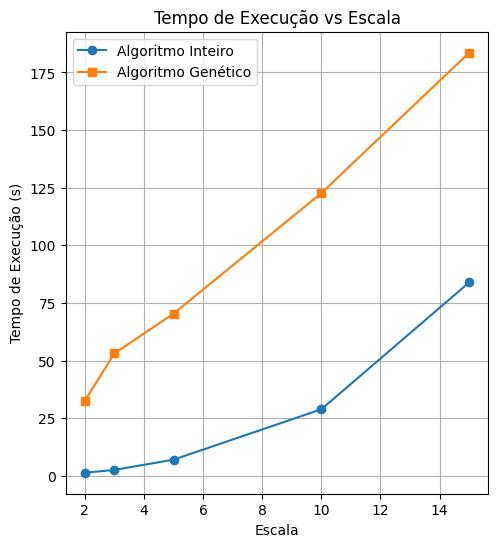

In [8]:
# Plotar Tempo vs Escala
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(escalas, temp_inteiro, marker='o', label='Algoritmo Inteiro')
plt.plot(escalas, temp_genetico, marker='s', label='Algoritmo Genético')
plt.title('Tempo de Execução vs Escala')
plt.xlabel('Escala')
plt.ylabel('Tempo de Execução (s)')
plt.legend()
plt.grid(True)

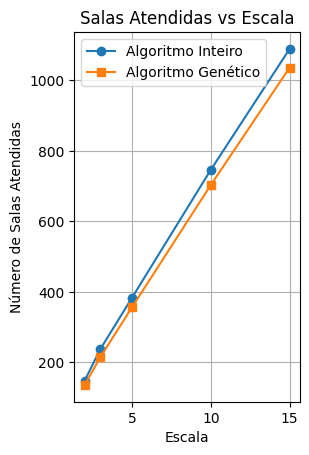

In [9]:
# Plotar Salas Atendidas vs Escala
plt.subplot(1, 2, 2)
plt.plot(escalas, salas_atendidas_inteiro, marker='o', label='Algoritmo Inteiro')
plt.plot(escalas, salas_atendidas_genetico, marker='s', label='Algoritmo Genético')
plt.title('Salas Atendidas vs Escala')
plt.xlabel('Escala')
plt.ylabel('Número de Salas Atendidas')
plt.legend()
plt.grid(True)